# 2D Fitting example

## Description
Task onsets are 320 and 960 seconds, each with duration of 320 seconds.


In [2]:
from fsl_mrs.utils import mrs_io
import numpy as np

example_data = mrs_io.read_FID('../simulated_data/fmrs_bold_3T/sub-001/mrs/sub-001_svs.nii.gz')
print(example_data)
print(example_data.hdr_ext['RepetitionTime'])
print(example_data.hdr_ext['RepetitionTime'] * example_data.shape[example_data.dim_position('DIM_DYN')])


task_onsets = np.array([320, 960]) 
task_durations = np.array([320, 320]) 
print(task_onsets / example_data.hdr_ext['RepetitionTime'])
print(task_durations / example_data.hdr_ext['RepetitionTime'])

This file's header extension is currently invalid. Reason: User-defined key ChemicalShiftOffset does not contain a 'Description' field. Setting empty 'Description'.
File sub-001_svs.nii.gz (/Users/wclarke/Library/CloudStorage/OneDrive-Nexus365/projects/special_issue_fmrs/simulated_data/fmrs_bold_3T/sub-001/mrs)
NIfTI-MRS version 0.2
Data shape (1, 1, 1, 2048, 1, 640)
Dimension tags: ['DIM_COIL', 'DIM_DYN', None]
Spectrometer Frequency: 123.0 MHz
Dwelltime (Spectral bandwidth): 1.667E-04 s (6000 Hz)
Nucleus: 1H
Field Strength: 2.89 T

2.5
1600.0
[128. 384.]
[128. 128.]


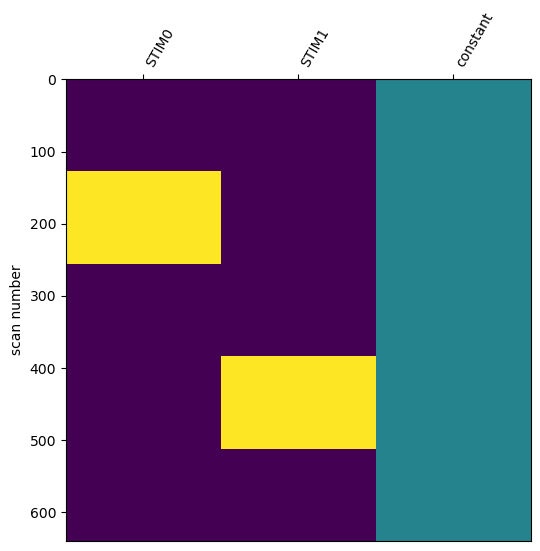

In [4]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Calculations to create the design matrix
tr          = example_data.hdr_ext['RepetitionTime']  # repetition time * number of transients averaged for this demo
n_blocks    = 2  # Number of stimulation blocks
n_scans     = example_data.shape[example_data.dim_position('DIM_DYN')] # Total number of scan points (16)
frame_times = np.arange(n_scans) * tr  # Time point of each data point
conditions  = [f'STIM{i}' for i in range(n_blocks)] # each trial gets its own regressor
duration    = task_durations # Duration of each stimulation block
onsets = task_onsets # Start time of each stimulation block.
events = pd.DataFrame({'trial_type': conditions, 
                       'onset'     : onsets,
                       'duration'  : duration})

# Pass to nilearn function to create design matrix
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model='polynomial',
    drift_order=0, 
    hrf_model=None) 

# Plot the designmatrix for inspection
fig = plt.figure(figsize=(6,6))
_ = plot_design_matrix(design_matrix, axes=fig.gca())

In [5]:
lb_df = pd.read_csv('../regressors/lorentz_lb_123_mhz.csv', index_col=0, names=['Lorentz_lb',])
lb_df.index = design_matrix.index
lb_df

,Lorentz_lb
0.0,0.228547
2.5,0.228547
5.0,0.228547
7.5,0.228547
10.0,0.228547
...,...
1587.5,0.228547
1590.0,0.228547
1592.5,0.228547
1595.0,0.228547


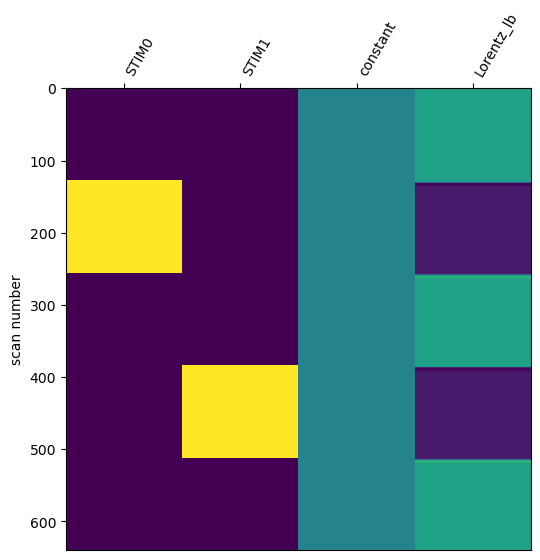

In [6]:
design_matrix_with_lb = pd.concat((design_matrix, lb_df),axis=1)

fig = plt.figure(figsize=(6,6))
_ = plot_design_matrix(design_matrix_with_lb, axes=fig.gca())

In [38]:
%%writefile dyn_models/fixed_lb.py

# Parameter - functional relationships
Parameters = {
'conc'     : {'dynamic':'model_glm','params':['STIM0', 'STIM1', 'constant']},
'gamma'    : 'fixed',
'sigma'    : 'fixed',
'eps'      : 'fixed',
'baseline' : 'fixed',
'Phi_0'    : 'fixed',
'Phi_1'    : 'fixed'
}

# Bounds on free fitted parameters
Bounds = {
'gamma' : (0,None),
'sigma' : (0,None),
'constant' : (0,None),
}

# Dynamic models
from numpy import dot
def model_glm(p,t):
    return dot(t,p)

# Dynamic model gradients
def model_glm_grad(p,t):
    return t.T

Writing dyn_models/fixed_lb.py


In [50]:
%%writefile dyn_models/exact_lb.py

# Parameter - functional relationships
Parameters = {
'conc'     : {'dynamic':'model_glm1','params':['STIM0', 'STIM1', 'constant']},
'gamma'    : {'dynamic':'model_glm2','params':['constant', 'Lorentz_lb']},
'sigma'    : 'fixed',
'eps'      : 'fixed',
'baseline' : 'fixed',
'Phi_0'    : 'fixed',
'Phi_1'    : 'fixed'
}

# Bounds on free fitted parameters
Bounds = {
'sigma' : (0,None),
'constant' : (0,None),
}

# Dynamic models
from numpy import dot
def model_glm1(p,t):
    return dot(t[:, :3],p)

# Dynamic model gradients
def model_glm1_grad(p,t):
    return t[:, :3].T

def model_glm2(p,t):
    return dot(t[:, -2:],p)

# Dynamic model gradients
def model_glm2_grad(p,t):
    return t[:, -2:].T

Overwriting dyn_models/exact_lb.py


In [7]:
design_matrix.to_csv('des_mat_3T_fixed_lb.csv', index=False, header=False)
design_matrix_with_lb.to_csv('des_mat_3T_exact_lb.csv', index=False, header=False)